# Dropout

## Concise Implementation

With high-level APIs, all we need to do is add a Dropout layer after each fully connected layer, passing in the dropout probability as the only argument to its constructor. During training, the Dropout layer will randomly drop out outputs of the previous layer (or equivalently, the inputs to the subsequent layer) according to the specified dropout probability. When not in training mode, the Dropout layer simply passes the data through during testing.

In [1]:
using Flux

dropout1, dropout2 = 0.2, 0.5
model = Chain(Flux.flatten,Dense(28*28=>256),relu,Dropout(dropout1),Dense(256,256),relu,Dropout(dropout2),Dense(256,10))

Chain(
  Flux.flatten,
  Dense(784 => 256),                    # 200_960 parameters
  NNlib.relu,
  Dropout(0.2),
  Dense(256 => 256),                    # 65_792 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(256 => 10),                     # 2_570 parameters
)                   # Total: 6 arrays, 269_322 parameters, 1.028 MiB.

Next, we train the model.

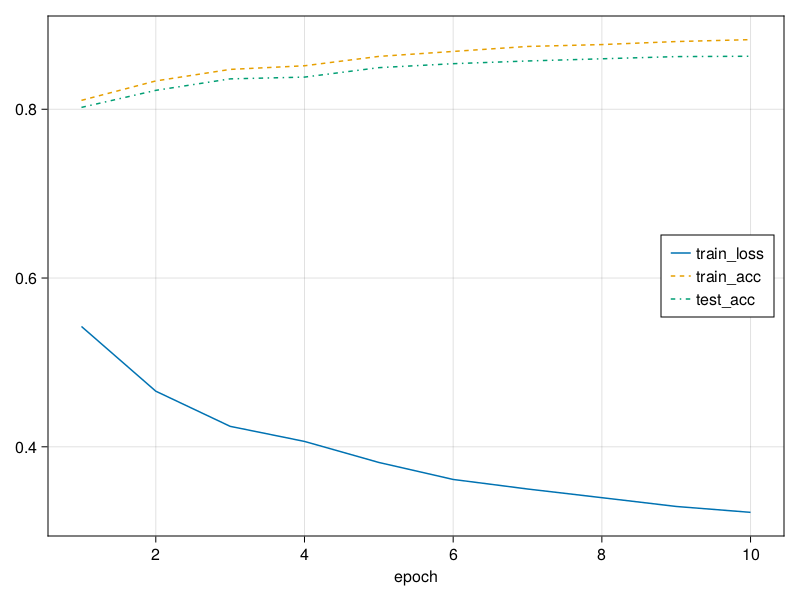

In [2]:
using MLUtils
using MLDatasets
using MLBase
using CairoMakie

# data prepare
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
mnist_train,mnist_test = FashionMNIST(:train),FashionMNIST(:test)
features = mnist_train.features
labels = Flux.onehotbatch(mnist_train.targets,0:9)
train_loader = DataLoader((features,labels),batchsize=256)

mnist_accuracy(model, data::FashionMNIST) = correctrate(classify(model(data.features)).-1,data.targets)
loss(model,x,y) = Flux.logitcrossentropy(model(x),y)

# train
num_epochs = 10
results = map(1:num_epochs) do i
    for data in train_loader
        Flux.train!(loss,model,[data],Descent())
    end
    loss(model,features,labels),mnist_accuracy(model,mnist_train),mnist_accuracy(model, mnist_test)
end
train_loss, train_acc, test_acc = map(x->getindex.(results,x),1:3)

#plot
f,ax = lines(train_loss,label="train_loss";axis=(;xlabel="epoch"))
lines!(ax,train_acc,label="train_acc",linestyle=:dash)
lines!(ax,test_acc,label="test_acc",linestyle=:dashdot)
axislegend(position = :rc)
f